This tutorial shows interoperability tools between Sopa and the Xenium Explorer. We show how to go back and forth, between analysis and visualization.

Ensure that you have already run Sopa, either with the Snakemake pipeline, CLI, or API.

For **image alignment** with the Xenium Explorer, refer to [this tutorial](https://gustaveroussy.github.io/sopa/tutorials/align/).

In [1]:
import sopa
import spatialdata

For this tutorial, we use some generated data that looks similar to the output of Sopa.

In [ ]:
### if you have your own data:
# sdata = spatialdata.read_zarr("...")

### to use the tutorial data
sdata = sopa.io.uniform(as_output=True)

In [23]:
explorer_path = "tuto.explorer" # where the Xenium Explorer data was or will be saved

Now, we need to create the Xenium Explorer input files. **If you have already run Sopa** on your own data, you don't need to run the lines below because you already have the Xenium Explorer input.

In [ ]:
### if you don't have the `.explorer` directory yet
sopa.io.write(explorer_path, sdata, gene_column="genes")

## Update the cell categories/clusters

Here, we run some Leiden clustering with `scanpy`. Then, we will update the Xenium Explorer files to display the spot clusters.

More generally, you can add new cell categories, i.e. a column of `sdata.table.obs`, and the Xenium Explorer will show it after the instructions below.

> Note that we only display categorical columns. If a column from `sdata.table.obs` contains continuous numerical values (e.g., `3.13, 7.89, ...`), it will not be transformed into a categorical variable, and therefore not shown in the Xenium Explorer. In this case, we recommend using the [`spatiadata_plot`](https://spatialdata.scverse.org/projects/plot/en/latest/index.html) static plotting library or the [`napari_spatialdata`](https://github.com/scverse/napari-spatialdata) interactive plotting library.

In [3]:
import scanpy as sc

adata = sdata.tables["table"]

In [4]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.1)

/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


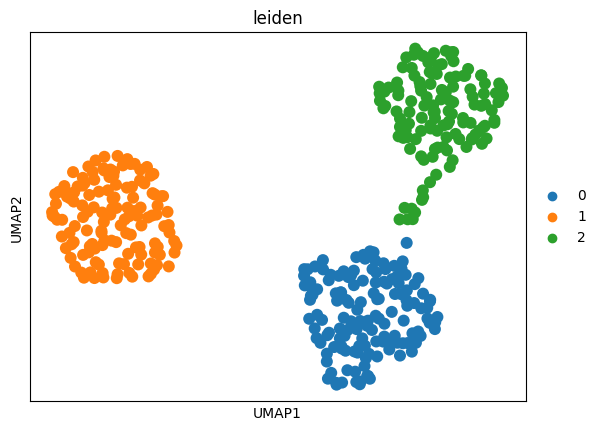

In [5]:
sc.pl.umap(adata, color="leiden")

Now, you can update the explorer with your new cluster assignment. You don't need to re-run the complete conversion; you can edit the `analysis.zarr.zip` file only, as below.

> Alternatively, you can use the `sopa` CLI instead of the API, as detailed [here](https://gustaveroussy.github.io/sopa/cli/#sopa-explorer-update-obs).

In [8]:
sopa.io.write_cell_categories(explorer_path, adata)

[INFO] (sopa.io.explorer.table) Writing 3 cell categories: region, slide, leiden


To visualize these clusters, re-open the `experiment.xenium` file and select the new `"leiden"` cell group (under the "Cells" panel and in the "Cell groups" dropdown). See the examples above to see how it looks on the Xenium Explorer.

<img src="../../../assets/explorer/leiden.png" alt="image" width="800" height="auto">

## Use the coordinates of a lasso selection in SpatialData

On the Xenium Explorer, you can use the Lasso or Rectangular selection tools to select some regions of interest. Then, you'll be able to analyze back this region of interest using `spatialdata`.


### Selecting cells from a selection
After making a selection, click on "Download Cell Stats as CSV", as below. It will create a file called `"Selection_1_cells_stats.csv"`.

<img src="../../../assets/explorer/lasso.png" alt="image" width="800" height="auto">

In [15]:
import pandas as pd

# write below the path to the file that you downloaded, e.g. "Selection_1_cells_stats.csv"
df_selection = pd.read_csv("Selection_1_cells_stats.csv", skiprows=2)

# we create a new column to annotate which cells were selected or not
adata.obs["lasso"] = "not-selected"
adata.obs.loc[df_selection["Cell ID"].values, "lasso"] = "selected"

Now, `sdata.table.obs["lasso"]` denotes which cells have been selected by the lasso tool (either "selected" or "not-selected").

We can then use `spatialdata_plot` to display the cells that were selected by the lasso tool. Make sure to install `spatialdata_plot >= 0.1.0`, e.g. via `pip install spatialdata_plot`. Now, we can render the shapes (i.e., the spots) and colour them based on the `"lasso"` column that was saved in `sdata.table.obs`:

In [16]:
import spatialdata_plot

/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata_plot/pl/basic.py:813: UserWarning: Converting copy of 'lasso' column to categorical dtype for categorical plotting. Consider converting before plotting.
  _render_shapes(


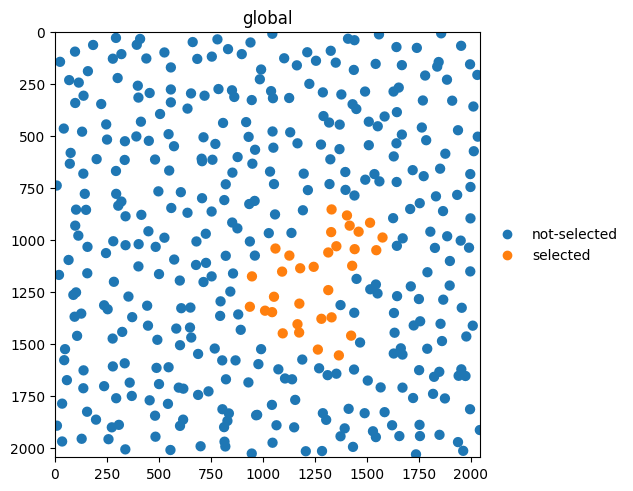

In [17]:
sdata.pl.render_shapes(color="lasso").pl.show("global")

### Cropping a SpatialData object from a selection

You can also export the whole selection as a polygon and use it to crop the `spatialdata` object. For that, click on "Download Selection Coordinates as CSV", as below. It will create a file called `"Selection_1_coordinates.csv"`.

<img src="../../../assets/explorer/lasso2.png" alt="image" width="800" height="auto">

Then, we read the polygon coordinates, and perform a polygon query on the `"global"` coordinate system (i.e., the pixel coordinate system).

> Note: if not using Xenium data, please provide the `pixel_size` argument in the `sopa.io.add_explorer_selection` function below (the `pixel_size` should be the one that has been used when running Sopa). If you used the snakemake pipeline, this argument can be found in the config. Without this, the polygon may not be in the right coordinate system.

In [19]:
import spatialdata_io

polygon = spatialdata_io.xenium_explorer_selection("Selection_1_coordinates.csv")

In [20]:
query_sdata = sdata.query.polygon(polygon, target_coordinate_system="global")
query_sdata

SpatialData object with:
├── Images
│     └── 'image': SpatialImage[cyx] (4, 1044, 837)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 4) (3D points)
├── Shapes
│     └── 'cellpose_boundaries': GeoDataFrame shape: (47, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (47, 5)
with coordinate systems:
▸ 'global', with elements:
        image (Images), transcripts (Points), cellpose_boundaries (Shapes)
▸ 'microns', with elements:
        transcripts (Points)

Using `spatialdata_plot`, we see that we indeed selected the cells we desired.

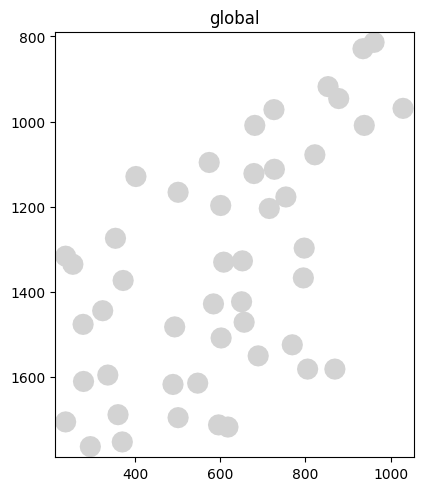

In [21]:
query_sdata.pl.render_shapes().pl.show("global")

## Segmentation overlay

Sometimes, you may need to select specific cells and update the segmentation accordingly. This can be specifically inetresting when you have multinucleated giant cells (MGC), which are difficult to segment. In that case, you can perform multiple lasso selections in the Xenium Explorer, and then download them all into one single file, as below.

<img src="../../../assets/explorer/multi_lasso.png" alt="image" width="800" height="auto">

Then, we can load the selection coordinates and save it as new `sdata` key. Here, we call it `"large_cells"`.

> Note: if not using Xenium data, please provide the `pixel_size` argument in the `sopa.io.add_explorer_selection` function below (the `pixel_size` should be the one that has been used when running Sopa). If you used the snakemake pipeline, this argument can be found in the config. Without this, the polygon may not be in the right coordinate system.

In [20]:
new_shapes_key = "large_cells"

sopa.io.add_explorer_selection(sdata, "coordinates.csv", shapes_key=new_shapes_key)

New shapes have been added to the `sdata` object:

In [19]:
sdata

SpatialData object with:
├── Images
│     └── 'image': SpatialImage[cyx] (4, 2048, 2048)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 4) (3D points)
├── Shapes
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (400, 1) (2D shapes)
│     └── 'large_cells': GeoDataFrame shape: (4, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (400, 5)
with coordinate systems:
▸ 'global', with elements:
        image (Images), transcripts (Points), cellpose_boundaries (Shapes), large_cells (Shapes)
▸ 'microns', with elements:
        transcripts (Points)

Now, we will update the segmentation. In particular, it will perform aggregation (i.e., counting the transcripts and/or averaging the channels inside the new cells), and it will remove cells that are behind the selected cells:

In [22]:
sopa.segmentation.overlay_segmentation(sdata, new_shapes_key, gene_column="genes")

[INFO] (sopa.segmentation.aggregate) Aggregating transcripts over 4 cells


[########################################] | 100% Completed | 106.88 ms


[INFO] (sopa.segmentation.aggregate) Averaging channels intensity over 4 cells with expansion 0.0


[########################################] | 100% Completed | 104.65 ms


/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:92: UserWarning: Key `large_cells` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/quentinblampey/mambaforge/envs/spatial/lib/python3.10/site-packages/spatialdata/_core/_elements.py:112: UserWarning: Key `table` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)


Now, we have a new table (the old table is also kept), and we have new shapes called `'cellpose_boundaries+large_cells'`.

In [23]:
sdata

SpatialData object with:
├── Images
│     └── 'image': SpatialImage[cyx] (4, 2048, 2048)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 4) (3D points)
├── Shapes
│     ├── 'cellpose_boundaries': GeoDataFrame shape: (400, 1) (2D shapes)
│     ├── 'cellpose_boundaries+large_cells': GeoDataFrame shape: (380, 1) (2D shapes)
│     └── 'large_cells': GeoDataFrame shape: (4, 1) (2D shapes)
└── Tables
      ├── 'old_table': AnnData (400, 5)
      └── 'table': AnnData (380, 5)
with coordinate systems:
▸ 'global', with elements:
        image (Images), transcripts (Points), cellpose_boundaries (Shapes), cellpose_boundaries+large_cells (Shapes), large_cells (Shapes)
▸ 'microns', with elements:
        transcripts (Points)

Now, we can update the Xenium Explorer.

For this, we provide `mode="-it"`, which means that images and transcripts will **not** be computed again. This is particular useful to save time: since we already have these files, they don't need to be updated.

In [24]:
sopa.io.write(
    explorer_path,
    sdata,
    shapes_key="cellpose_boundaries+large_cells",
    gene_column="genes",
    mode="-it",
)

[INFO] (sopa.io.explorer.table) Writing table with 5 columns
[INFO] (sopa.io.explorer.table) Writing 4 cell categories: region, slide, leiden, lasso
[INFO] (sopa.io.explorer.shapes) Writing 380 cell polygons
[INFO] (sopa.io.explorer.converter) Saved files in the following directory: tuto.explorer
[INFO] (sopa.io.explorer.converter) You can open the experiment with 'open tuto.explorer/experiment.xenium'


It will lead to the following visualization, i.e. the old cells with an overlay of the cells that we selected with the lasso tool:

<img src="../../../assets/explorer/post_overlay.png" alt="image" width="800" height="auto">